In [271]:
import numpy as np
import math
from scipy import linalg
from sympy import symbols, solve

import cv2 as cv
import matplotlib.pyplot as plt

# Singular Value Decomposition 

In [272]:
img = cv.imread('lena.png')
img = cv.resize(img, (144, 100))
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [273]:
mat1 = np.asarray(gray_img, dtype=float)
mat2 = np.array([[3, 1, 1],
                [-1, 3, 1]], dtype=float)
mat3 = np.array([[1, 1],
                [0, 1],
                [1, 0]], dtype=float)

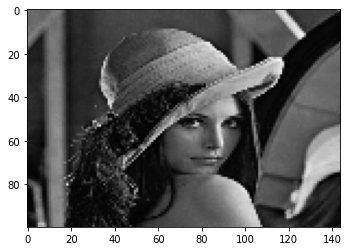

In [274]:
plt.imshow(mat1, cmap="gray")

In [275]:
def sign(number):
    return 1 if (round(number, 3) > 0) else -1

def getNorm(vals):
    return math.sqrt(sum(list(map(lambda x: x**2, vals))))

def hypotenuse(a, b):
    return math.sqrt(a**2 + b**2)

In [276]:
def getEigen(smat):
    # Params
    hess, singularMatrix = linalg.hessenberg(smat, calc_q=True)
    diag = [np.float64(val) for val in np.diag(hess)]
    subdElmt = [np.float64(val) for val in np.diag(hess, -1)]
    eps = 1.e-20
    
    # Start
    n = len(diag)
    itermax = 1/eps**2
    subdElmt.append(0)

    for l in range(n):
        j = 0
        while True:
            m = l
            while True:
                # Convergence test
                if (m + 1) == n:
                    break
                if abs(subdElmt[m]) <= eps * (abs(diag[m]) + abs(diag[m + 1])):
                    break 
                m += 1
            
            if m == l:
                break 
            
            if j >= itermax:
                raise RuntimeError(f"No convergence to eigenvalue after {j} iteration.")

            j += 1

            # Form shift
            p = diag[l]
            g = (diag[l + 1] - p) / (2 * subdElmt[l])
            r = hypotenuse(g, 1)

            # Avoiding cancelation
            s = g + sign(g)*r

            g = diag[m] - p + subdElmt[l] / s

            s, c, p = 1, 1, 0

            for i in range(m - 1, l - 1, -1):
                f = s * subdElmt[i]
                b = c * subdElmt[i]
                if abs(f) > abs(g):
                    c = g / f 
                    r = hypotenuse(c, 1)
                    subdElmt[i + 1] = f * r 
                    s = 1 / r
                    c *= s
                else:
                    s = f / g 
                    r = hypotenuse(s, 1)
                    subdElmt[i + 1] = g * r 
                    c = 1 / r 
                    s *= c 
                
                g = diag[i + 1] - p 
                r = (diag[i] - g) * s + 2 * c * b 
                p = s * r 
                diag[i + 1] = g + p 
                g = c * r - b 

                # Compute eigenvectors
                for w in range(singularMatrix.shape[0]):
                    f = singularMatrix[w, i + 1]
                    singularMatrix[w, i + 1] = s * singularMatrix[w, i] + c * f
                    singularMatrix[w, i] = c * singularMatrix[w, i] - s * f 

            diag[l] -= p; subdElmt[l] = g; subdElmt[m] = 0

    sortedIdx = np.argsort(diag, )[::-1][:n]
    eigenval = diag.copy()
    eigenval.sort(reverse=True)
    singularMatrix = singularMatrix[:, sortedIdx]

    negIdx = [eigenval.index(val) for val in eigenval if val < 0]
    for i in negIdx:
        eigenval[i] *= -1
        singularMatrix[i, :] *= -1

    return eigenval, singularMatrix

In [277]:
# Matrix singular
mat = mat1.copy()
row, col = mat.shape
flipped = False

if (row < col):
    mat = mat.T
    row, col = mat.shape
    flipped = True

sleft = np.matmul(mat, mat.T)
sright = np.matmul(mat.T, mat)

In [278]:
# eigvalLeft, u = getEigen(sleft)
u = np.zeros((row, row))
eigvalRight, v = getEigen(sright)

In [279]:
# if (row > col):
#     sigmaVal = [math.sqrt(x) for x in eigvalLeft]
# else:
sigmaVal = [math.sqrt(x) for x in eigvalRight]

sigma = np.zeros((row, col))
np.fill_diagonal(sigma, sigmaVal)

In [280]:
for i in range(col):
    u[:, i] = (mat @ v[:, i]) / sigmaVal[i]

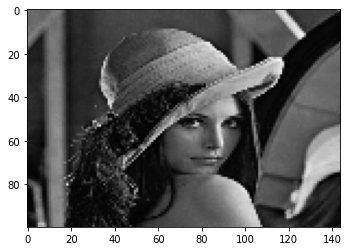

In [281]:
display = u @ sigma @ v.T
if flipped:
    display = display.T

plt.imshow(display, cmap="gray")